In [1]:
# --------------------------------------------------------------------------

# ----------------- mccr results d0005 for chemometrica 2019 journal paper

# -------------------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os

#base_dir = "C:/Users/u0106869/Google Drive/kul_phd/conferences/chemometrica-2019/paper/chemometrica2019_conference_paper_codes_submission02"
base_dir = "/home/valeria/vfonsecad/kul_phd/conferences/chemometrica-2019/paper/chemometrica2019_conference_paper_codes_submission02"


# --- data handling modules

import numpy as np
import pandas as pd
import scipy.io as sp_io

# --- visualization modules

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import seaborn as sns
import imageio
from matplotlib.cm import ScalarMappable
from matplotlib import rcParams
import matplotlib as mtply


# --- my modules

methods_dir = base_dir + '/methods/python'  
sys.path.insert(0, methods_dir + '/model_building')
sys.path.insert(0, methods_dir + '/read_data')
from class_chemometrics_data import chemometrics_data
from class_mccr import mccr, mccr_sklearn
from class_weighted_mcesimpls import weighted_mcesimpls, weighted_mcesimpls_sklearn




# ¡¡¡ --- !!! # ---> base working directory and available data cases


# ************************************ init --- user 
cases_dict = {"d0005": ["d0005_milkrobot_visnir2010", "trans_lactose_robpca_data_prepared"]}
# ************************************ end --- user 


print("--------- imports loaded ----------")




# ¡¡¡ --- !!! # ---> data


# ************************************ init --- user 
caseID_key = "d0005"
# ************************************ end --- user 

case_dir = cases_dict[caseID_key][0]
dname = cases_dict[caseID_key][1]
data_dir = '/data/' + case_dir + '/data_prepared/'
output_dir = base_dir + '/output/'





# ************************************ init --- user
data_class = chemometrics_data(base_dir + data_dir + dname + '.mat', 
                               data_identifier = data_dir + dname,
                               include_val = True,
                               include_test = False,
                               include_unlabeled = False,
                               y_all_range = False, 
                               y_range = np.array([2]))
# ************************************ end --- user





print("--------- data loaded for " + data_class.data_identifier + "----------")






--------- imports loaded ----------
--------- data loaded for /data/d0005_milkrobot_visnir2010/data_prepared/trans_lactose_robpca_data_prepared!*Lactose*!----------


In [2]:
# ¡¡¡ --- !!! # ---> results of tuning for all models

tuning_results = {}
print("ready")

ready


In [3]:
# ¡¡¡ --- !!! # ---> tuning for MCCR

#cont = input("Start?   ")
print("\n start time:---", datetime.datetime.now(), "\n")


# ************************************ init --- user 

lambda_min = 0.0000001
lambda_max = 0.01
total_lambdas = 30

sigma_min = 1
sigma_max = 1
total_sigmas = 1


kfold_splits = 10
maximum_iters  = 30

# ************************************ end --- user 





lambda_range = np.linspace(lambda_min, lambda_max, total_lambdas)
sigma_range = np.linspace(sigma_min, sigma_max, total_sigmas)
val_error_matrix = np.zeros((total_lambdas,sigma_range.shape[0]))
cv_error_matrix = np.zeros((total_lambdas,sigma_range.shape[0]))


ssi = 0

for sigma_i in sigma_range:
    
    lli = 0
    
    for lambda_i in lambda_range:  
        
        # --- model object
        
        my_mccr = mccr(data_class.get_cal()["xcal"],data_class.get_cal()["ycal"], lambda_i, "my_mccr")

        # --- training model

        try:
            

            my_mccr_trained = my_mccr.train(iters=maximum_iters, factor_sigma=sigma_i)
            # --- Sample weights

            my_mccr_sample_weights  = np.diag(my_mccr_trained["sample_weights"])
            my_mccr_sample_weights.shape = (data_class.ncal,1)

            # --- cv    

            my_mccr_cv_pred = my_mccr.crossval_KFold(my_mccr_trained['trainObject'],number_splits=kfold_splits)
            my_mccr_cv_error = my_mccr.rmse(my_mccr_cv_pred['cvPredicted'], data_class.get_cal()["ycal"],my_mccr_sample_weights)

            # --- val    

            yval_pred_mccr = my_mccr.predict(data_class.get_val()["xval"],my_mccr_trained)
            my_mccr_val_error = my_mccr.rmse(yval_pred_mccr, data_class.get_val()["yval"])

        except np.linalg.LinAlgError:
            

            my_mccr_cv_error = None
            my_mccr_val_error = None



        # --- Store error 


        val_error_matrix[lli,ssi] = my_mccr_val_error
        cv_error_matrix[lli,ssi] = my_mccr_cv_error
        
        lli += 1
        print(lli)

    ssi += 1
    print(ssi)
        
    
tuning_results["mccr"] = {"cv_error": cv_error_matrix,
                                "val_error": val_error_matrix,
                                "sigma_range": sigma_range,
                          "lambda_range": lambda_range
                                }




print("\n finish time:---", datetime.datetime.now())


 start time:--- 2019-12-11 14:28:08.404853 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1

 finish time:--- 2019-12-11 15:14:48.648392


[1.]


Text(0.5, 1.0, '$\\sigma^2$')

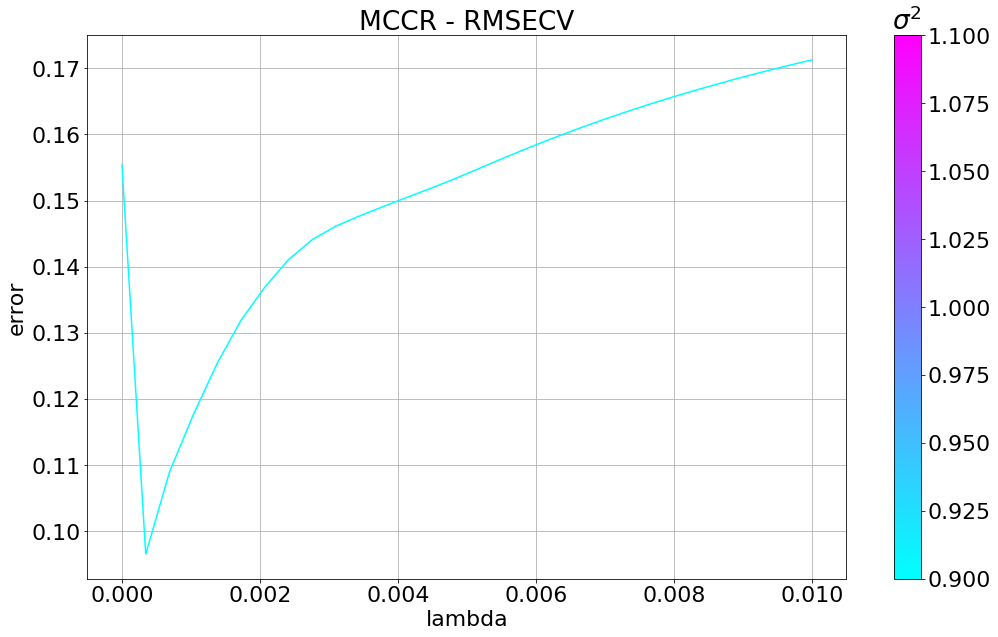

In [4]:
# ¡¡¡ --- !!! # ---> plots of cv mccr

print(tuning_results["mccr"]["sigma_range"])

plt.rcParams.update({'font.size': 22}) 


    # --- colormap 
    
c_m = mtply.cm.cool
norm = mtply.colors.Normalize(vmin = np.amin(tuning_results["mccr"]["sigma_range"]),
                              vmax = np.amax(tuning_results["mccr"]["sigma_range"]))
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)
s_m.set_array([])

    # --- plot

fig, ax = plt.subplots(figsize = (17,10), facecolor="white")
for ii in range(tuning_results["mccr"]["cv_error"].shape[1]):
    plt.plot(lambda_range,tuning_results["mccr"]["cv_error"][:,ii],color=s_m.to_rgba(tuning_results["mccr"]["sigma_range"][ii]))
plt.title("MCCR - RMSECV")
plt.xlabel("lambda")
plt.ylabel("error")
#plt.ylim([0.1,0.3])
plt.grid()
clb = plt.colorbar(s_m)
clb.ax.set_title("$\sigma^2$")
#plt.show() 
#plt.savefig(output_dir + 'figures/fig_' + case_dir + '02_rmsecv_mccr.png', format='png',bbox_inches = 'tight')


In [5]:
# ¡¡¡ --- !!! # ---> check min RMSECV
selected_lambda = lambda_range[np.argmin(tuning_results["mccr"]["cv_error"][:,0])]
selected_lambda

0.0003449241379310345

In [2]:
# ¡¡¡ --- !!! # ---> selected models for all algorithms

selected_models = {}

print("ready")

ready


In [3]:
# ¡¡¡ --- !!! # ---> selected models W.MCESIMPLS


# ************************************ init --- user 
selected_models["mccr"] = {"model_01": {"lambda": 0.0003, "sigma2":1}}
kfold_splits = 10
current_V = None
maximum_iters  = 30

# ************************************ end --- user 



for model_i in selected_models["mccr"].keys():
    

    
    
    
    my_mccr = mccr(data_class.get_cal()["xcal"],data_class.get_cal()["ycal"], selected_models["mccr"][model_i]["lambda"], "my_mccr")

        # --- training model

    try:
        
            

        my_mccr_trained = my_mccr.train(iters=maximum_iters, factor_sigma=selected_models["mccr"][model_i]["sigma2"])
            # --- Sample weights

        my_mccr_sample_weights  = np.diag(my_mccr_trained["sample_weights"])
        my_mccr_sample_weights.shape = (data_class.ncal,1)

            # --- cv    

        my_mccr_cv_pred = my_mccr.crossval_KFold(my_mccr_trained['trainObject'],number_splits=kfold_splits)
        my_mccr_cv_error = my_mccr.rmse(my_mccr_cv_pred['cvPredicted'], data_class.get_cal()["ycal"],my_mccr_sample_weights)
        my_mccr_cv_r2 = my_mccr.r2(my_mccr_cv_pred['cvPredicted'], data_class.get_cal()["ycal"],my_mccr_sample_weights)

            # --- val    

        yval_pred_mccr = my_mccr.predict(data_class.get_val()["xval"],my_mccr_trained)
        my_mccr_val_error = my_mccr.rmse(yval_pred_mccr, data_class.get_val()["yval"])
        my_mccr_val_r2 = my_mccr.r2(yval_pred_mccr, data_class.get_val()["yval"])
    
 
    except np.linalg.LinAlgError:
        
        my_weighted_mcesimpls_cv_error = None
        my_weighted_mcesimpls_val_error = None
    
    selected_models["mccr"][model_i]["rmsecv"] = my_mccr_cv_error[0]
    selected_models["mccr"][model_i]["r2cv"] = my_mccr_cv_r2[0]
    selected_models["mccr"][model_i]["rmsep"] = my_mccr_val_error[0]
    selected_models["mccr"][model_i]["r2p"] = my_mccr_val_r2[0]
    selected_models["mccr"][model_i]["trained"] = my_mccr_trained
    selected_models["mccr"][model_i]["sample_weights"] = my_mccr_sample_weights
                                           
    
    print(model_i)

print("finished")

model_01
finished


In [4]:
# ¡¡¡ --- !!! # ---> selected models table


empty_line = {"algorithm": [], "model_id": [], "lambda": [], "sigma2": [], "h":[] , "rmsecv":[], "r2cv": [], "rmsep":[], "r2p":[]}
selected_models_table = pd.DataFrame(data=empty_line)


for alg_i in selected_models.keys():
    
    for model_i in selected_models[alg_i].keys():
                
        new_line = {"algorithm": alg_i, "model_id" : model_i}
        
        for key_i in selected_models[alg_i][model_i].keys():
            if key_i in ["lambda", "sigma2", "rmsecv", "r2cv", "rmsep", "r2p"]:
                new_line.update({key_i:selected_models[alg_i][model_i][key_i]})

        selected_models_table = selected_models_table.append(new_line,ignore_index=True)

selected_models_table

algorithm  model_id  lambda  sigma2   h   rmsecv      r2cv     rmsep  \
0      mccr  model_01  0.0003     1.0 NaN  0.09419  0.912037  0.104121   

        r2p  
0  0.834456

In [6]:
# ¡¡¡ --- !!! # ---> select one model from the table

one_selected_model = selected_models_table.iloc[0,:]

current_model_all_results = selected_models[one_selected_model["algorithm"]][one_selected_model["model_id"]]

print("ready")


mccr_model_01_sample_weights = {"sample_weights":current_model_all_results["sample_weights"]}

sp_io.savemat(base_dir + data_dir + 'mccr_model_01_sample_weights' + '.mat'   , mccr_model_01_sample_weights)


ready


In [33]:
# ¡¡¡ --- !!! # ---> one selected model scores 2D plot


plt.rcParams.update({'font.size': 22}) 

color_var_dict = {"weights_i": [mtply.cm.winter, current_model_all_results["sample_weights"], "weights"],
    "weights": [mtply.cm.winter_r, current_model_all_results["sample_weights"], "weights"]}

if one_selected_model["algorithm"] == "simpls":
    x_scores_title = "SIMPLS - CORN"
    color_var_name = "weights_i"

else:
    x_scores_title = "MCW-PLS - CORN " +  "$\sigma^2=$" + str(current_model_all_results["sigma2"]) 
    color_var_name = "weights"




# --- weights plot



rsimpls_sample_weights_mat = sp_io.loadmat(base_dir + data_dir + "rsimpls_model_01_sample_flags.mat")

plt.rcParams.update({'font.size': 22}) 
fig, ax = plt.subplots(figsize = (12,8), facecolor="white")
plt.plot(data_class.get_cal()["ycal"][:,0],rsimpls_sample_weights_mat["sample_weights"][:,0], 'D',color="orange",markersize = 8, label = "RSIMPLS (model 1)", alpha = 1)
plt.plot(data_class.get_cal()["ycal"][:,0],current_model_all_results["sample_weights"][:,0], 'P',color="green",markersize = 8, label = "MCCR (model 1)", alpha = 0.5)
plt.xlabel("y observed")
plt.ylabel("sample weights")
plt.title("SAMPLE WEIGHTS COMPARISON")
plt.grid()
plt.legend()
plt.show()
#plt.savefig(output_dir + 'figures/fig_' + case_dir + '03_sample_weights_comparison.png', format='png',bbox_inches = 'tight')







In [37]:
# ¡¡¡ --- !!! # ---> select samples single models analysis of w.mcesimpls with high-weight samples


sample_proportions = [0.99,0.95,0.90,0.85,0.80,0.70,0.6,0.5]




#  --- subsample selected models table

empty_line = {"algorithm": [], "model_id": [], "percentage_weights": [],"ncal": [],"ncp": [], "rmsecv":[], "r2cv":[],"rmsep":[], "r2p":[]}
subsample_models_table = pd.DataFrame(data=empty_line)




#  --- subsample selected model single models analysis of w.mcesimpls with high-weight samples

for ii in range(len(sample_proportions)):
    
    print(ii)
    
    selected_samples = (current_model_all_results["sample_weights"]>=sample_proportions[ii]).flatten()



    my_simpls_subsample = weighted_mcesimpls(data_class.get_cal()["xcal"][selected_samples,:],data_class.get_cal()["ycal"][selected_samples,:], 15, "my_subsample_simpls")

      # --- training model

    my_simpls_subsample_trained = my_simpls_subsample.train(iters=0, current_v0=None, robpca_check = False)

        # --- Sample weights

    my_simpls_subsample_weights  = np.diag(my_simpls_subsample_trained["sample_weights"])
    my_simpls_subsample_weights.shape = (selected_samples.sum(),1)

            # --- cv    

    my_simpls_subsample_cv_pred = my_simpls_subsample.crossval_KFold(my_simpls_subsample_trained['trainObject'],number_splits=kfold_splits)
    my_simpls_subsample_cv_error = my_simpls_subsample.rmse(my_simpls_subsample_cv_pred['cvPredicted'], data_class.get_cal()["ycal"][selected_samples,:],my_simpls_subsample_weights)
    my_simpls_subsample_cv_r2 = my_simpls_subsample.r2(my_simpls_subsample_cv_pred['cvPredicted'], data_class.get_cal()["ycal"][selected_samples,:],my_simpls_subsample_weights)

    
    
      # --- val    

    yval_pred_simpls_subsample = my_simpls_subsample.predict(data_class.get_val()["xval"],my_simpls_subsample_trained)
    my_simpls_subsample_val_error = my_simpls_subsample.rmse(yval_pred_simpls_subsample, data_class.get_val()["yval"])
    my_simpls_subsample_val_r2 = my_simpls_subsample.r2(yval_pred_simpls_subsample, data_class.get_val()["yval"])


    new_line = {"algorithm": "simpls", "model_id" : ii}
    new_line["percentage_weights"] = sample_proportions[ii]
    new_line["ncal"] =  selected_samples.sum()
    new_line["ncp"] = my_simpls_subsample_trained["x_scores"].shape[1]
    new_line["rmsecv"] = my_simpls_subsample_cv_error[0]
    new_line["r2cv"] = my_simpls_subsample_cv_r2[0]
    new_line["rmsep"] = my_simpls_subsample_val_error[0]
    new_line["r2p"] = my_simpls_subsample_val_r2[0]

    subsample_models_table = subsample_models_table.append(new_line,ignore_index=True)




subsample_models_table

0
1
2
3
4
5
6
7


algorithm  model_id  percentage_weights   ncal   ncp    rmsecv      r2cv  \
0    simpls       0.0                0.99   38.0  15.0  0.079798  0.944075   
1    simpls       1.0                0.95   82.0  15.0  0.046234  0.974191   
2    simpls       2.0                0.90  116.0  15.0  0.050118  0.969661   
3    simpls       3.0                0.85  137.0  15.0  0.050671  0.970333   
4    simpls       4.0                0.80  148.0  15.0  0.053378  0.967970   
5    simpls       5.0                0.70  166.0  15.0  0.059076  0.962788   
6    simpls       6.0                0.60  185.0  15.0  0.064743  0.959296   
7    simpls       7.0                0.50  200.0  15.0  0.070873  0.949982   

      rmsep       r2p  
0  0.164232  0.618636  
1  0.125006  0.762283  
2  0.115047  0.798965  
3  0.111945  0.809000  
4  0.106375  0.825469  
5  0.106129  0.829032  
6  0.100267  0.846712  
7  0.098409  0.852907

In [24]:
# ¡¡¡ --- !!! # ---> cross val single models analysis of w.mcesimpls with high-weight samples


selected_samples = (current_model_all_results["sample_weights"]>=0.9).flatten()

# ************************************ init --- user 
total_ncp = 30
kfold_splits = 10
# ************************************ end --- user 



range_ncp = np.arange(1, total_ncp+1)
val_error_matrix = np.zeros((total_ncp,1))
cv_error_matrix = np.zeros((total_ncp,1))


ssi = 0


    
for current_ncp in range_ncp:  
        
    # --- model object
        
    my_simpls = weighted_mcesimpls(data_class.get_cal()["xcal"][selected_samples,:],data_class.get_cal()["ycal"][selected_samples,:], current_ncp, "my_simpls")

    # --- training model

    try:
            

        my_simpls_trained = my_simpls.train(iters=0, current_v0=None, robpca_check = False)
            
        # --- Sample weights

        my_simpls_sample_weights  = np.diag(my_simpls_trained["sample_weights"])
        my_simpls_sample_weights.shape = (data_class.get_cal()["xcal"][selected_samples,:].shape[0],1)

        # --- cv    

        my_simpls_cv_pred = my_simpls.crossval_KFold(my_simpls_trained['trainObject'],number_splits=kfold_splits)
        my_simpls_cv_error = my_simpls.rmse(my_simpls_cv_pred['cvPredicted'], data_class.get_cal()["ycal"][selected_samples,:],my_simpls_sample_weights)

        # --- val    

        yval_pred_simpls = my_simpls.predict(data_class.get_val()["xval"],my_simpls_trained)
        my_simpls_val_error = my_simpls.rmse(yval_pred_simpls, data_class.get_val()["yval"])

    except np.linalg.LinAlgError:
            

        my_simpls_cv_error = None
        my_simpls_val_error = None



    # --- Store error 


    val_error_matrix[current_ncp-1,ssi] = my_simpls_val_error
    cv_error_matrix[current_ncp-1,ssi] = my_simpls_cv_error


    
        
    
tuning_results_subsample = {"cv_error": cv_error_matrix,
                             "val_error": val_error_matrix}




print("\n finish time:---", datetime.datetime.now())

plt.rcParams.update({'font.size': 22}) 

    # --- plot

fig, ax = plt.subplots(figsize = (17,10), facecolor="white")
for ii in range(tuning_results_subsample["cv_error"].shape[1]):
    plt.plot(tuning_results_subsample["cv_error"][:,ii],color="red", linewidth=3)
plt.title("simpls - rmsecv - subsample")
plt.xlabel("lv")
plt.ylabel("error")
plt.xticks(np.arange(0,tuning_results_subsample["cv_error"].shape[0]), np.arange(1,tuning_results_subsample["cv_error"].shape[0]+1).astype(int))
plt.grid()
plt.show() 


 finish time:--- 2019-12-11 17:17:04.862957
